In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
import nltk
import re
import string
from string import punctuation
from nltk import ngrams
from nltk.tokenize import word_tokenize 
import html
#!pip install TextBlob
#!pip install imbalanced-learn
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
test_df = pd.read_csv('drugsComTest_raw.tsv', sep = '\t')
train_df = pd.read_csv('drugsComTrain_raw.tsv', sep = '\t')

In [3]:
#Merging the two datasets 
frames = [test_df, train_df]
df = pd.concat(frames)


df.rename(columns={'Unnamed: 0':'uniqueid'}, inplace=True )
df.columns = df.columns.str.lower()

df.head(5)

,uniqueid,drugname,condition,review,rating,date,usefulcount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


# Data Description 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   uniqueid     215063 non-null  int64  
 1   drugname     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulcount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


In [5]:
df.dtypes

uniqueid         int64
drugname        object
condition       object
review          object
rating         float64
date            object
usefulcount      int64
dtype: object

In [6]:
df.shape

(215063, 7)

In [7]:
df.describe()

,uniqueid,rating,usefulcount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


# Data Cleaning

In [8]:
#Searching for NA values 
print("Missing Data Table")
df.isnull().sum()

Missing Data Table


uniqueid          0
drugname          0
condition      1194
review            0
rating            0
date              0
usefulcount       0
dtype: int64

In [9]:
size = df.shape[0]
condition_na = df['condition'].isnull().sum()

print(f'Percentage of NA values in conditions: {condition_na/size*100}%')

Percentage of NA values in conditions: 0.5551861547546533%


In [10]:
df = df.dropna()
print("Missing Value Table")
print(df.isnull().sum())
print()
print('New Data Shape:', df.shape)

Missing Value Table
uniqueid       0
drugname       0
condition      0
review         0
rating         0
date           0
usefulcount    0
dtype: int64

New Data Shape: (213869, 7)


In [11]:
df.sort_values(['uniqueid'], ascending = True, inplace = True)
df.reset_index(drop = True, inplace = True)
df.head(10)

,uniqueid,drugname,condition,review,rating,date,usefulcount
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,"October 28, 2015",4
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,"October 27, 2015",11
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8.0,"October 27, 2015",7
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9.0,"October 26, 2015",12
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1.0,"October 25, 2015",4
5,6,Medroxyprogesterone,Birth Control,"""This is a horrible shot!! I got my first shot...",1.0,"October 24, 2015",3
6,7,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 18 and got this for heavy bleeding. ...",5.0,"October 22, 2015",6
7,8,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Im 19 and have been having heavy and painful ...",5.0,"October 21, 2015",2
8,9,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m a 30 year old woman. I got the shot ...",2.0,"October 21, 2015",5
9,10,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 17 years old and I got shot in Augus...",7.0,"October 20, 2015",2


In [12]:
df.duplicated().sum()

0

In [13]:
df.describe()

,uniqueid,rating,usefulcount
count,213869.000000,213869.000000,213869.000000
mean,116076.924786,6.991149,28.094118
std,67016.705794,3.275792,36.401377
min,0.000000,1.000000,0.000000
25%,58122.000000,5.000000,6.000000
50%,115972.000000,8.000000,16.000000
75%,174018.000000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [14]:
#Conditions contains incorrect values
unique_conditions = df['condition'].unique()
unique_conditions.sort()
unique_conditions

array(['0</span> users found this comment helpful.',
       '100</span> users found this comment helpful.',
       '105</span> users found this comment helpful.',
       '10</span> users found this comment helpful.',
       '110</span> users found this comment helpful.',
       '11</span> users found this comment helpful.',
       '121</span> users found this comment helpful.',
       '123</span> users found this comment helpful.',
       '12</span> users found this comment helpful.',
       '135</span> users found this comment helpful.',
       '13</span> users found this comment helpful.',
       '142</span> users found this comment helpful.',
       '145</span> users found this comment helpful.',
       '146</span> users found this comment helpful.',
       '14</span> users found this comment helpful.',
       '15</span> users found this comment helpful.',
       '16</span> users found this comment helpful.',
       '17</span> users found this comment helpful.',
       '18</span> us

In [15]:
#There is incorrect conditions that contain 'users found this comment helpful.' and does not contain a condition 
df.loc[df['condition'].str.contains('users found this comment helpful.'), 'condition'] = None

In [16]:
print("Incorrect Html Tagged Conditions Table")
print(df.isnull().sum())

Incorrect Html Tagged Conditions Table
uniqueid          0
drugname          0
condition      1171
review            0
rating            0
date              0
usefulcount       0
dtype: int64


In [17]:
size = df.shape[0]
condition_na = df['condition'].isnull().sum()

print(f'Percentage of Corrupted values in conditions: {condition_na/size*100}%')

Percentage of Corrupted values in conditions: 0.5475314327929715%


In [18]:
df = df.dropna()
print("Missing Value Table")
print(df.isnull().sum())
print()
print('New Data Shape:', df.shape)

Missing Value Table
uniqueid       0
drugname       0
condition      0
review         0
rating         0
date           0
usefulcount    0
dtype: int64

New Data Shape: (212698, 7)


In [19]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Preprocessing Reviews

In [20]:
def review_clean(review): 
    lower = review.str.lower()
    pat_rem = lower.str.replace("&#039;", "")
    spec_rem = pat_rem.str.replace(r'[^\w\d\s]',' ')
    ascii_rem = spec_rem.str.replace(r'[^\x00-\x7F]+',' ')
    space_rem = ascii_rem.str.replace(r'^\s+|\s+?$','')
    multiw_remove = space_rem.str.replace(r'\s+',' ')
    df = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return df

In [21]:
df['review_clean'] = review_clean(df['review'])

<ipython-input-20-285af68ff6b5>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  spec_rem = pat_rem.str.replace(r'[^\w\d\s]',' ')
<ipython-input-20-285af68ff6b5>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  ascii_rem = spec_rem.str.replace(r'[^\x00-\x7F]+',' ')
<ipython-input-20-285af68ff6b5>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  space_rem = ascii_rem.str.replace(r'^\s+|\s+?$','')
<ipython-input-20-285af68ff6b5>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  multiw_remove = space_rem.str.replace(r'\s+',' ')
<ipython-input-20-285af68ff6b5>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df = multiw_remove.str.replace(r'\.{2,}', ' ')


In [22]:
df.head(3)

,uniqueid,drugname,condition,review,rating,date,usefulcount,review_clean
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,2015-10-28,4,been on the depo injection since january 2015 ...
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,2015-10-27,11,im 21 years old and recently found out i might...
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8.0,2015-10-27,7,i have been on the shot 11 years and until a m...


In [23]:
#Used for remouving punctuation
from string import punctuation 
df['review_clean'] = df['review_clean'].apply(lambda x: ''.join(word for word in x if word not in punctuation))

In [24]:
#removing numbers 
df['review_clean'] = df['review_clean'].str.replace('\d+', '')

<ipython-input-24-ecbee070b3e0>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_clean'] = df['review_clean'].str.replace('\d+', '')


In [25]:
#Removing stop words 
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
df['review_clean'] = df['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [26]:
#Lemmitization and word tokenization 
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [27]:
df['text_lemmatized'] = df.review_clean.apply(lemmatize_text)

In [28]:
#This is converting the lemmetized words into a string and storing them within the clean review
df['review_clean'] = [','.join(map(str, l)) for l in df['text_lemmatized']]
df['review_clean'] = df['review_clean'].replace(',',' ', regex=True)

In [29]:
df.head(3)

,uniqueid,drugname,condition,review,rating,date,usefulcount,review_clean,text_lemmatized
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,2015-10-28,4,depo injection since january bleeding stopped ...,"[depo, injection, since, january, bleeding, st..."
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,2015-10-27,11,im year old recently found might pcos havent g...,"[im, year, old, recently, found, might, pcos, ..."
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8.0,2015-10-27,7,shot year month ago never period even spotting...,"[shot, year, month, ago, never, period, even, ..."


In [30]:
del df['text_lemmatized']
del df['usefulcount']
del df['date']

In [31]:
df.head(3)

,uniqueid,drugname,condition,review,rating,review_clean
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,depo injection since january bleeding stopped ...
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,im year old recently found might pcos havent g...
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8.0,shot year month ago never period even spotting...


#  Polarity Lexicon Approach

<h3>TextBlob</h3>

In [32]:
from tqdm import tqdm

In [33]:
reviews = df["review_clean"]
sentiments = []
subjectivity = []

for review in tqdm(reviews):
    blob = TextBlob(review)
    sentiments += [blob.sentiment.polarity]
    subjectivity += [blob.sentiment.subjectivity]

100%|██████████| 212698/212698 [04:12<00:00, 843.20it/s] 


In [34]:
textblob_df = df.copy()

textblob_df["polarity"] = sentiments
textblob_df["subjectivity"] = subjectivity

In [35]:
textblob_df.head(3)

,uniqueid,drugname,condition,review,rating,review_clean,polarity,subjectivity
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,depo injection since january bleeding stopped ...,-0.160714,0.442857
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,im year old recently found might pcos havent g...,0.186429,0.441032
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8.0,shot year month ago never period even spotting...,-0.075000,0.709722


In [36]:
textblob_df['polarity'].describe()

count    212698.000000
mean          0.066307
std           0.235980
min          -1.000000
25%          -0.050000
50%           0.058974
75%           0.187083
max           1.000000
Name: polarity, dtype: float64

In [37]:
np.corrcoef(df["rating"], textblob_df["polarity"])

array([[1.        , 0.33345986],
       [0.33345986, 1.        ]])

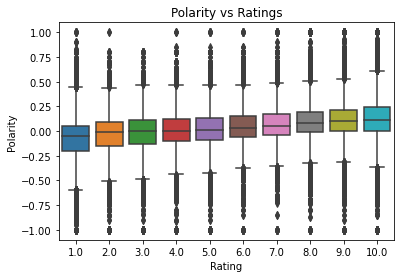

In [38]:
sns.boxplot(x=np.array(textblob_df["rating"]),y=np.array(textblob_df["polarity"]))
plt.xlabel("Rating")
plt.ylabel("Polarity")
plt.title("Polarity vs Ratings")
plt.show()

C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'TextBlob Polarity Distribution')

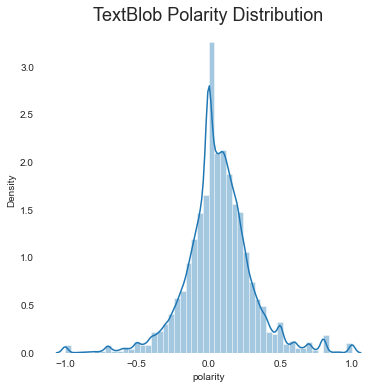

In [39]:
plt.figure(figsize=(6,6))
sns.set_style('white')
sns.distplot(textblob_df['polarity'])
plt.box(False)
plt.title("TextBlob Polarity Distribution", fontsize=18)

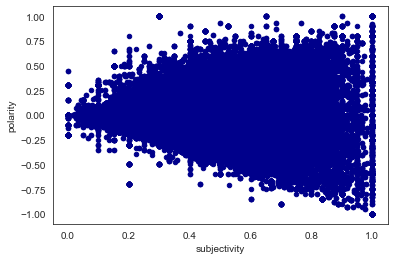

In [40]:
pol_sub = textblob_df.plot.scatter(x='subjectivity',
                     y='polarity',                       
                     c='DarkBlue')

In [41]:
#Creating Labels for Textblob Polarity score
textblob_df.loc[(textblob_df['polarity'] > 0), 'sentiment'] = 1
textblob_df.loc[(textblob_df['polarity'] == 0 ), 'sentiment'] = 0
textblob_df.loc[(textblob_df['polarity'] < 0), 'sentiment'] = -1

In [42]:
textblob_df.head(3)

,uniqueid,drugname,condition,review,rating,review_clean,polarity,subjectivity,sentiment
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,depo injection since january bleeding stopped ...,-0.160714,0.442857,-1.0
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,im year old recently found might pcos havent g...,0.186429,0.441032,1.0
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8.0,shot year month ago never period even spotting...,-0.075000,0.709722,-1.0


In [43]:
textblob_df['sentiment'].value_counts()

 1.0    131182
-1.0     70248
 0.0     11268
Name: sentiment, dtype: int64

C:\Users\vanes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

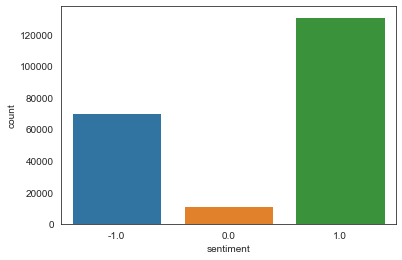

In [44]:
sns.countplot(textblob_df['sentiment'])

<h3>VADER</h3>

In [45]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vanes\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [46]:
vader_df = df.copy()

In [47]:
vader_df.head(3)

,uniqueid,drugname,condition,review,rating,review_clean
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,depo injection since january bleeding stopped ...
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,im year old recently found might pcos havent g...
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8.0,shot year month ago never period even spotting...


In [48]:
def encode_reviews(review):
    return html.unescape(review) # Decode in utf-8 and convert HTML characters

print("Review example: ", vader_df.loc[0, 'review_clean']) # Example of review text

vader_df['review_clean'] = vader_df['review_clean'].apply(encode_reviews) # Let's clean the text...

vader_df.head(2)

Review example:  depo injection since january bleeding stopped another injection june didnt bleed month started spotting mid july since approx august st bleeding constantly heavy enough use pad almost november im sick bleeding forking money sanitary pad shouldnt bleeding well long currently awaiting ultrasound see happening would like change contraceptive doctor wont let


,uniqueid,drugname,condition,review,rating,review_clean
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,depo injection since january bleeding stopped ...
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,im year old recently found might pcos havent g...


In [49]:
sid = SentimentIntensityAnalyzer() 

"""
Only run the bottom three lines if there is time. This step takes a few minutes
"""
#vader_df["neg_score"] = vader_df["review_clean"].apply(lambda x: sid.polarity_scores(x)["neg"])
#vader_df["neu_score"] = vader_df["review_clean"].apply(lambda x: sid.polarity_scores(x)["neu"])
#vader_df["pos_score"] = vader_df["review_clean"].apply(lambda x: sid.polarity_scores(x)["pos"])

vader_df["v_polarity"] = vader_df["review_clean"].apply(lambda x: sid.polarity_scores(x)["compound"])

In [50]:
vader_df.head(3)

,uniqueid,drugname,condition,review,rating,review_clean,v_polarity
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,depo injection since january bleeding stopped ...,-0.5024
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,im year old recently found might pcos havent g...,0.7650
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8.0,shot year month ago never period even spotting...,-0.1779


In [51]:
np.corrcoef(vader_df["rating"], vader_df["v_polarity"])

array([[1.       , 0.3012931],
       [0.3012931, 1.       ]])

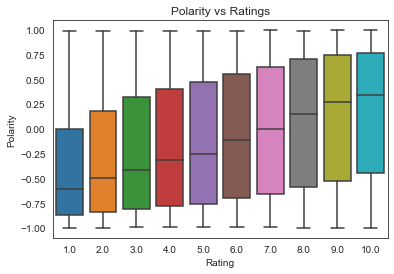

In [52]:
sns.boxplot(x=np.array(vader_df["rating"]),y=np.array(vader_df["v_polarity"]))
plt.xlabel("Rating")
plt.ylabel("Polarity")
plt.title("Polarity vs Ratings")
plt.show()

C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'VADER Polarity Distribution')

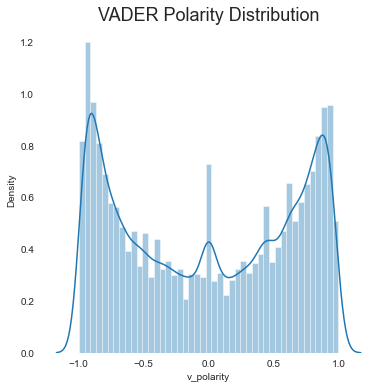

In [53]:
plt.figure(figsize=(6,6))
sns.set_style('white')
sns.distplot(vader_df['v_polarity'])
plt.box(False)
plt.title("VADER Polarity Distribution", fontsize=18)

In [54]:
vader_df.loc[(vader_df['v_polarity'] > 0), 'sentiment'] = 1
vader_df.loc[(vader_df['v_polarity'] == 0), 'sentiment'] = 0
vader_df.loc[(vader_df['v_polarity'] < 0), 'sentiment'] = -1

In [55]:
vader_df.head(3)

,uniqueid,drugname,condition,review,rating,review_clean,v_polarity,sentiment
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,depo injection since january bleeding stopped ...,-0.5024,-1.0
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,im year old recently found might pcos havent g...,0.7650,1.0
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8.0,shot year month ago never period even spotting...,-0.1779,-1.0


In [56]:
vader_df['sentiment'].value_counts()

 1.0    103557
-1.0    103417
 0.0      5724
Name: sentiment, dtype: int64

C:\Users\vanes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

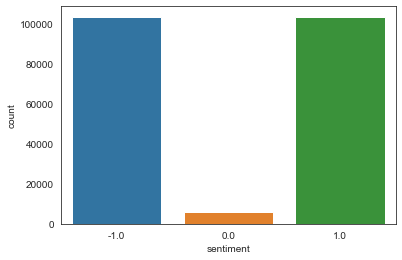

In [57]:
sns.countplot(vader_df['sentiment'])

<h3>Average Polarity (TextBlob and Vader)</h3>

In [58]:
avg_df = df.copy()

In [59]:
avg_df.head(2)

,uniqueid,drugname,condition,review,rating,review_clean
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,depo injection since january bleeding stopped ...
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,im year old recently found might pcos havent g...


In [60]:
avg_df['tb_pol'] = textblob_df["polarity"]
avg_df['vd_pol'] = vader_df["v_polarity"]

In [61]:
avg_df['polarity'] = avg_df[['tb_pol', 'vd_pol']].mean(axis=1)

In [62]:
avg_df.head(3)

,uniqueid,drugname,condition,review,rating,review_clean,tb_pol,vd_pol,polarity
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,depo injection since january bleeding stopped ...,-0.160714,-0.5024,-0.331557
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,im year old recently found might pcos havent g...,0.186429,0.7650,0.475714
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8.0,shot year month ago never period even spotting...,-0.075000,-0.1779,-0.126450


In [63]:
np.corrcoef(avg_df["rating"], avg_df["polarity"])

array([[1.        , 0.34819486],
       [0.34819486, 1.        ]])

C:\Users\vanes\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Average Polarity Distribution')

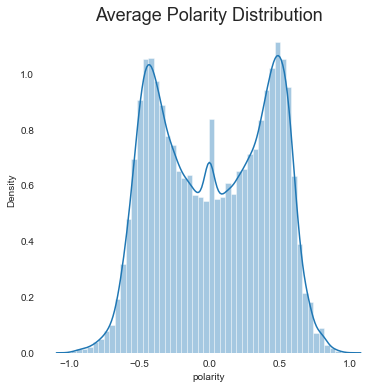

In [64]:
plt.figure(figsize=(6,6))
sns.set_style('white')
sns.distplot(avg_df['polarity'])
plt.box(False)
plt.title("Average Polarity Distribution", fontsize=18)

In [65]:
#avg_df['sentiment'] = pd.qcut(avg_df['polarity'], 2, labels = [0, 1])

avg_df.loc[(avg_df['polarity'] > 0), 'sentiment'] = 1
avg_df.loc[(avg_df['polarity'] == 0 ), 'sentiment'] = 0
avg_df.loc[(avg_df['polarity'] < 0), 'sentiment'] = -1

In [66]:
avg_df.head(3)

,uniqueid,drugname,condition,review,rating,review_clean,tb_pol,vd_pol,polarity,sentiment
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3.0,depo injection since january bleeding stopped ...,-0.160714,-0.5024,-0.331557,-1.0
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,im year old recently found might pcos havent g...,0.186429,0.7650,0.475714,1.0
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8.0,shot year month ago never period even spotting...,-0.075000,-0.1779,-0.126450,-1.0


In [67]:
avg_df['sentiment'].value_counts()

 1.0    109101
-1.0    100917
 0.0      2680
Name: sentiment, dtype: int64

C:\Users\vanes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

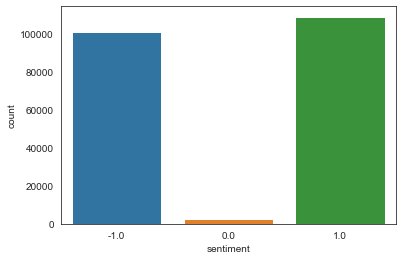

In [68]:
sns.countplot(avg_df['sentiment'])

# Splitting the Data

In [100]:
df['tb_sentiment'] = textblob_df['sentiment']
df['vd_sentiment'] = vader_df['sentiment']
df['sentiment'] = avg_df['sentiment']

Everything past this step is repeated multiple times. Data Collected is manually entered within Assessing_Results.ipynb to undergo further evaluation. Some of the steps take mintues to accomplish and as such it was run multiple time on different occations

In [101]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df,test_size=0.30, shuffle = True)

In [102]:
X_train = train.review_clean
X_test = test.review_clean
Y_train =  train.sentiment
Y_test = test.sentiment

In [103]:
print('Train data shape ',X_train.shape,Y_train.shape)
print('Test data shape ',X_test.shape,Y_test.shape)

Train data shape  (148888,) (148888,)
Test data shape  (63810,) (63810,)


C:\Users\vanes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

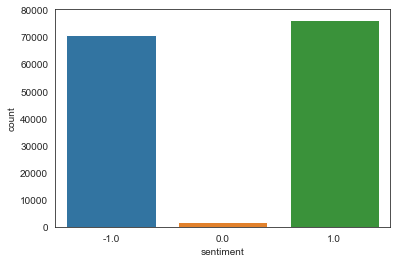

In [104]:
sns.countplot(train.sentiment)

# Modelling and Feature Engineering 

<h3>Term Frequency/Count Vectorizer</h3>

In [105]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()#min_df = 0.005, max_df = 0.50

In [123]:
#Vectorizing the text data
X_train_dtm = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

In [124]:
X_train_dtm.shape

(148888, 41213)

In [125]:
#Balencing the dataset
oversample = SMOTE(random_state = 1)
undersample = RandomUnderSampler()
steps = [("o", oversample), ("u", undersample)]
pipeline = Pipeline(steps=steps)
X_train_dtm, Y_train = pipeline.fit_resample(X_train_dtm,Y_train)

In [126]:
counter = Counter(Y_train) #Change Y_train_'dtm'
for k, v in counter.items():
    dist = v / len(Y_train)*100
    print(f"Class: {k}, n: {v}, ({dist}%)")

Class: -1.0, n: 76243, (33.33333333333333%)
Class: 0.0, n: 76243, (33.33333333333333%)
Class: 1.0, n: 76243, (33.33333333333333%)


In [127]:
print('Train data shape ',X_train_dtm.shape,Y_train.shape)#Change Y_train_dtm
print('Test data shape ',X_test_dtm.shape,Y_test.shape)

Train data shape  (228729, 41213) (228729,)
Test data shape  (63810, 41213) (63810,)


<h4>Multinomial Naive Bayes</h4>

In [97]:
from sklearn.naive_bayes import MultinomialNB #import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix #import confusion_matrix
from sklearn import model_selection   
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import sklearn.model_selection
from sklearn.model_selection import cross_val_score

In [153]:
nb_dtm = MultinomialNB().fit(X_train_dtm, Y_train) #fit the training data
pred = nb_dtm.predict(X_test_dtm)

In [154]:
print("Accuracy: %s" % str(nb_dtm.score(X_test_dtm, Y_test))) #check accuracy
print("Confusion Matrix") 
print(confusion_matrix(pred, Y_test))

Accuracy: 0.7723084156088388
Confusion Matrix
[[23421   160  7287]
 [   83   449   160]
 [ 6651   188 25411]]


In [155]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

        -1.0       0.76      0.78      0.77     30155
         0.0       0.65      0.56      0.60       797
         1.0       0.79      0.77      0.78     32858

    accuracy                           0.77     63810
   macro avg       0.73      0.70      0.72     63810
weighted avg       0.77      0.77      0.77     63810



In [146]:
accuracies = cross_val_score(estimator = nb_dtm, X = X_train_dtm, y = Y_train, cv = 10, scoring = 'accuracy')
precision = cross_val_score(estimator = nb_dtm, X = X_train_dtm, y = Y_train, scoring="precision_macro", cv = 10)
recall = cross_val_score(estimator = nb_dtm, X = X_train_dtm, y = Y_train, scoring="recall_macro", cv = 10)
f1 = cross_val_score(estimator = nb_dtm, X = X_train_dtm, y = Y_train, scoring="f1_macro", cv = 10)

print("Accuracies:", accuracies)
print()
print("Precisions:", precision)
print()
print("Recall:", recall)
print()
print("F1 Score:", f1)

Accuracies: [0.82717615 0.82918725 0.82647663 0.762165   0.75836139 0.76089713
 0.75477637 0.76006645 0.75412058 0.73600909]

Precisions: [0.8319778  0.83373522 0.83137917 0.79167846 0.78948738 0.79144366
 0.78734281 0.79004108 0.7852953  0.74997466]

Recall: [0.82717853 0.82918956 0.82647888 0.76216631 0.75836309 0.76089845
 0.75477577 0.76006576 0.75411998 0.73600909]

F1 Score: [0.82915287 0.83107578 0.8284934  0.76801995 0.7641611  0.7669292
 0.7609362  0.76605103 0.76033913 0.73977163]


<h4>Decision Trees</h4>

In [81]:
from sklearn.tree import DecisionTreeClassifier

In [256]:
dt_dtm = DecisionTreeClassifier()
dt_dtm.fit(X_train_dtm, Y_train)

DecisionTreeClassifier()

In [257]:
print("Accuracy: %s" % str(dt_dtm.score(X_test_dtm, Y_test))) #check accuracy
print("Confusion Matrix") 
print(confusion_matrix(pred, Y_test))

Accuracy: 0.8536593010499922
Confusion Matrix
[[23333   185  7246]
 [   60   439   129]
 [ 6713   210 25495]]


In [258]:
print(dt_dtm.tree_.max_depth)

717


Hypertuning the Decision Tree - viewing the best max_depth for the tree

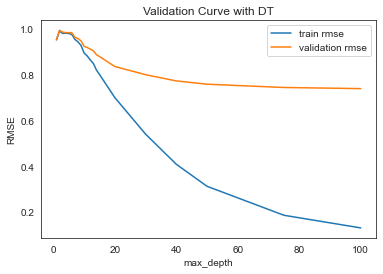

In [259]:
from sklearn.model_selection import validation_curve

param_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,40,50,75,100]

train_scores, valid_scores = validation_curve(estimator = DecisionTreeClassifier(random_state=1), X= X_train_dtm, y = Y_train, 
                                              param_name = "max_depth", param_range = param_range, 
                                              scoring='neg_mean_squared_error', cv=3)
train_scores = np.sqrt(np.abs(train_scores))
valid_scores = np.sqrt(np.abs(valid_scores))

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.title("Validation Curve with DT")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.plot(param_range, train_scores_mean, label="train rmse")
plt.plot(param_range, valid_scores_mean, label="validation rmse")

plt.legend()
plt.show()

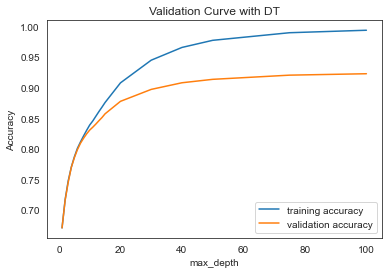

In [85]:
from sklearn.model_selection import validation_curve
param_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,40,50,75,100]

train_scores, valid_scores = validation_curve(estimator = DecisionTreeClassifier(random_state=1), X= X_train_dtm, y = Y_train, 
                                              param_name = "max_depth", param_range = param_range, 
                                           scoring='accuracy', cv=3)
train_scores = np.sqrt(np.abs(train_scores))
valid_scores = np.sqrt(np.abs(valid_scores))

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.title("Validation Curve with DT")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.plot(param_range, train_scores_mean, label="training accuracy")
plt.plot(param_range, valid_scores_mean, label="validation accuracy")

plt.legend()
plt.show()

In [86]:
#using cross fold validation to see wchin max_depth has the best accuarcy 
max_depth = [20, 22, 24, 26, 28, 30, 32, 34, 36]

for val in max_depth:
    score = cross_val_score(DecisionTreeClassifier(max_depth= val, random_state= 42), X_train_dtm, 
                            Y_train, cv= 3, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(20): 0.770
Average score(22): 0.780
Average score(24): 0.788
Average score(26): 0.794
Average score(28): 0.800
Average score(30): 0.805
Average score(32): 0.810
Average score(34): 0.813
Average score(36): 0.818


In [86]:
#Testing out the best parameters
dt_dtm = DecisionTreeClassifier(max_depth = 32)
dt_dtm.fit(X_train_dtm, Y_train)

DecisionTreeClassifier(max_depth=32)

In [87]:
pred = dt_dtm.predict(X_test_dtm)

In [88]:
print("Accuracy: %s" % str(dt_dtm.score(X_test_dtm, Y_test))) #check accuracy
print("Confusion Matrix") 
print(confusion_matrix(pred, Y_test))

Accuracy: 0.7601786553831688
Confusion Matrix
[[22744    73  5720]
 [ 1543   628  1836]
 [ 6061    70 25135]]


In [91]:
from sklearn.metrics import classification_report
from sklearn import metrics

print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

        -1.0       0.80      0.74      0.77     30290
         0.0       0.16      0.81      0.26       773
         1.0       0.80      0.77      0.78     32747

    accuracy                           0.76     63810
   macro avg       0.58      0.77      0.60     63810
weighted avg       0.79      0.76      0.77     63810



In [97]:
#Preforming 10-fold Cross validation
accuracies = cross_val_score(estimator = dt_dtm, X = X_train_dtm, y = Y_train, cv = 10, scoring = 'accuracy')
print(accuracies)

[0.8296154  0.83109966 0.82995722 0.82659565 0.82716319 0.83135423
 0.82921505 0.82629006 0.83200908 0.77905352]


In [98]:
accuracies.mean()

0.8242353064041505

In [99]:
precision = cross_val_score(estimator = dt_dtm, X = X_train_dtm, y = Y_train, scoring="precision_macro", cv = 10)
print(precision)

[0.82649523 0.82936238 0.82744577 0.82371043 0.82359563 0.82652308
 0.82637308 0.82459331 0.82845765 0.77996449]


In [100]:
precision.mean()

0.8216521036472265

In [101]:
recall = cross_val_score(estimator = dt_dtm, X = X_train_dtm, y = Y_train, scoring="recall_macro", cv = 10)
print(recall)

[0.82962232 0.83154307 0.82904475 0.82603214 0.82514788 0.83016854
 0.83069242 0.82798562 0.83166276 0.78106219]


In [102]:
recall.mean()

0.824296169902125

In [89]:
f1 = cross_val_score(estimator = dt_dtm, X = X_train_dtm, y = Y_train, scoring="f1_macro", cv = 10)
print(f1)

[0.8249809  0.82722766 0.82926719 0.82504334 0.82967537 0.82657598
 0.82524355 0.82717308 0.82433287 0.76648865]


In [90]:
f1.mean()

0.8206008594164409

<h4>LR<h4>

In [86]:
# make a prediction with a multinomial logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [128]:
lr_dtm = LogisticRegression(multi_class='multinomial', solver='lbfgs',  C=1.0, max_iter = 1000).fit(X_train_dtm, Y_train) 
pred = lr_dtm.predict(X_test_dtm)

In [129]:
print("Accuracy: %s" % str(lr_dtm.score(X_test_dtm, Y_test))) #check accuracy
print("Confusion Matrix") 
print(confusion_matrix(pred, Y_test))

Accuracy: 0.8915530481115812
Confusion Matrix
[[26943    43  3422]
 [  154   718   207]
 [ 3058    36 29229]]


In [130]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

        -1.0       0.89      0.89      0.89     30155
         0.0       0.67      0.90      0.77       797
         1.0       0.90      0.89      0.90     32858

    accuracy                           0.89     63810
   macro avg       0.82      0.89      0.85     63810
weighted avg       0.89      0.89      0.89     63810



In [131]:
accuracies = cross_val_score(estimator = lr_dtm, X = X_train_dtm, y = Y_train, cv = 10, scoring = 'accuracy')

print("Accuracies:", accuracies)
print("Mean:", accuracies.mean())

Accuracies: [0.92545796 0.9264198  0.92440869 0.92497705 0.92904298 0.9255454
 0.92497705 0.92672583 0.92117344 0.85182756]
Mean: 0.9180555756899492


In [156]:
precision = cross_val_score(estimator = lr_dtm, X = X_train_dtm, y = Y_train, scoring="precision_macro", cv = 10)

print("Precisions:", precision)
print("Mean:", precision.mean())

Precisions: [0.92516562 0.92613644 0.92408636 0.92464019 0.92880292 0.92526644
 0.92467634 0.9264283  0.92087899 0.85560059]
Mean: 0.9181682177858039


In [157]:
recall = cross_val_score(estimator = lr_dtm, X = X_train_dtm, y = Y_train, scoring="recall_macro", cv = 10)

print("Recall:", recall)
print("Mean:", recall.mean())

Recall: [0.92545945 0.92642121 0.92441018 0.92497387 0.92903999 0.92554231
 0.92497869 0.92672765 0.92117506 0.85182756]
Mean: 0.9180555977958591


In [158]:
f1 = cross_val_score(estimator = lr_dtm, X = X_train_dtm, y = Y_train, scoring="f1_macro", cv = 10)

print("F1 Score:", f1)
print("Mean:", f1.mean())

F1 Score: [0.92530005 0.92626316 0.92423402 0.92479288 0.92891088 0.92539452
 0.92481467 0.92654627 0.92101736 0.84627945]
Mean: 0.9173553249261861


<h3>TF-IDF</h3>

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer() 

In [75]:
X_train = train.review_clean
X_test = test.review_clean
Y_train =  train.sentiment
Y_test = test.sentiment

In [76]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [77]:
X_train_tfidf.shape

(148888, 41122)

In [78]:
oversample = SMOTE(random_state = 1)
undersample = RandomUnderSampler()
steps = [("o", oversample), ("u", undersample)]
pipeline = Pipeline(steps=steps)
X_train_tfidf, Y_train = pipeline.fit_resample(X_train_tfidf,Y_train)

In [79]:
counter = Counter(Y_train) #Change Y_train_'dtm'
for k, v in counter.items():
    dist = v / len(Y_train)*100
    print(f"Class: {k}, n: {v}, ({dist}%)")

Class: -1.0, n: 76483, (33.33333333333333%)
Class: 0.0, n: 76483, (33.33333333333333%)
Class: 1.0, n: 76483, (33.33333333333333%)


In [80]:
print('Train data shape ',X_train_tfidf.shape,Y_train.shape)
print('Test data shape ',X_test_tfidf.shape,Y_test.shape)

Train data shape  (229449, 41122) (229449,)
Test data shape  (63810, 41122) (63810,)


<h4>NB</h4>

In [108]:
nb_tfidf = MultinomialNB().fit(X_train_tfidf, Y_train) #fit the training data
pred = nb_tfidf.predict(X_test_tfidf)

In [109]:
print("Accuracy: %s" % str(nb_tfidf.score(X_test_tfidf, Y_test))) #check accuracy
print("Confusion Matrix") 
print(confusion_matrix(pred, Y_test))

Accuracy: 0.7716815546152641
Confusion Matrix
[[23624   119  7477]
 [  115   557   186]
 [ 6519   153 25060]]


In [110]:
from sklearn.metrics import classification_report
from sklearn import metrics

print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

        -1.0       0.76      0.78      0.77     30258
         0.0       0.65      0.67      0.66       829
         1.0       0.79      0.77      0.78     32723

    accuracy                           0.77     63810
   macro avg       0.73      0.74      0.74     63810
weighted avg       0.77      0.77      0.77     63810



In [112]:
accuracies = cross_val_score(estimator = nb_tfidf, X = X_train_tfidf, y = Y_train, cv = 10, scoring = 'accuracy')
precision = cross_val_score(estimator = nb_tfidf, X = X_train_tfidf, y = Y_train, scoring="precision_macro", cv = 10)
recall = cross_val_score(estimator = nb_tfidf, X = X_train_tfidf, y = Y_train, scoring="recall_macro", cv = 10)
f1 = cross_val_score(estimator = nb_tfidf, X = X_train_tfidf, y = Y_train, scoring="f1_macro", cv = 10)

print("Accuracies:", accuracies, "Mean:", accuracies.mean())
print()
print("Precisions:", precision, "Mean:", precision.mean())
print()
print("Recall:", recall, "Mean:", recall.mean())
print()
print("F1 Score:", f1, "Mean:", f1.mean())


Accuracies: [0.81020337 0.81578947 0.81496029 0.81386925 0.81023873 0.81621787
 0.81320648 0.81215904 0.81573779 0.82437917] Mean: 0.8146761453219599

Precisions: [0.81811826 0.82319269 0.82278482 0.82166906 0.81871878 0.82368018
 0.82076681 0.8197051  0.82284686 0.83162482] Mean: 0.8223107372161653

Recall: [0.81020337 0.81578947 0.81496029 0.81386925 0.8102366  0.81621532
 0.81321015 0.81216271 0.81573617 0.82437864] Mean: 0.814676198615888

F1 Score: [0.81309124 0.81854152 0.81784857 0.81669829 0.81327326 0.81892812
 0.81599499 0.81496688 0.81841133 0.82682441] Mean: 0.8174578602684732


<h4>Decision Tree<h4>

In [113]:
dt_tfidf = DecisionTreeClassifier()
dt_tfidf.fit(X_train_tfidf, Y_train)

DecisionTreeClassifier()

In [114]:
pred = dt_tfidf.predict(X_test_tfidf)

In [116]:
print("Accuracy: %s" % str(dt_tfidf.score(X_test_tfidf, Y_test))) #check accuracy
print("Confusion Matrix") 
print(confusion_matrix(pred, Y_test))

Accuracy: 0.8577495690330669
Confusion Matrix
[[25908    40  4526]
 [   97   735   107]
 [ 4253    54 28090]]


In [117]:
print(dt_tfidf.tree_.max_depth)

558


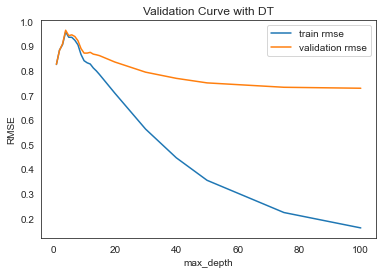

In [119]:
from sklearn.model_selection import validation_curve

param_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,40,50,75,100]

train_scores, valid_scores = validation_curve(estimator = DecisionTreeClassifier(random_state=1), X= X_train_tfidf, y = Y_train, 
                                              param_name = "max_depth", param_range = param_range, 
                                              scoring='neg_mean_squared_error', cv=3)
train_scores = np.sqrt(np.abs(train_scores))
valid_scores = np.sqrt(np.abs(valid_scores))

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.title("Validation Curve with DT")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.plot(param_range, train_scores_mean, label="train rmse")
plt.plot(param_range, valid_scores_mean, label="validation rmse")

plt.legend()
plt.show()

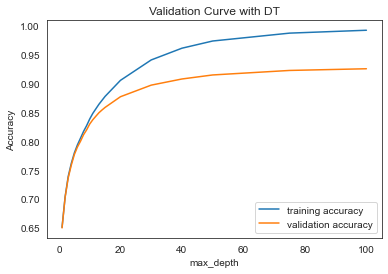

In [120]:
from sklearn.model_selection import validation_curve
param_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,40,50,75,100]

train_scores, valid_scores = validation_curve(estimator = DecisionTreeClassifier(random_state=1), X= X_train_tfidf, y = Y_train, 
                                              param_name = "max_depth", param_range = param_range, 
                                           scoring='accuracy', cv=3)
train_scores = np.sqrt(np.abs(train_scores))
valid_scores = np.sqrt(np.abs(valid_scores))

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.title("Validation Curve with DT")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.plot(param_range, train_scores_mean, label="training accuracy")
plt.plot(param_range, valid_scores_mean, label="validation accuracy")

plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import validation_curve
param_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,40,50,75,100]

train_scores, valid_scores = validation_curve(estimator = DecisionTreeClassifier(random_state=1), X= X_train_tfidf, y = Y_train, 
                                              param_name = "max_depth", param_range = param_range, 
                                           scoring='accuracy', cv=3)
train_scores = np.sqrt(np.abs(train_scores))
valid_scores = np.sqrt(np.abs(valid_scores))

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.title("Validation Curve with DT")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.plot(param_range, train_scores_mean, label="training accuracy")
plt.plot(param_range, valid_scores_mean, label="validation accuracy")

plt.legend()
plt.show()

In [125]:
dt_tfidf = DecisionTreeClassifier(max_depth = 45)
dt_tfidf.fit(X_train_tfidf, Y_train)

DecisionTreeClassifier(max_depth=20)

In [126]:
pred = dt_tfidf.predict(X_test_tfidf)

In [127]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

        -1.0       0.75      0.64      0.69     30258
         0.0       0.10      0.93      0.19       829
         1.0       0.75      0.70      0.72     32723

    accuracy                           0.67     63810
   macro avg       0.53      0.76      0.53     63810
weighted avg       0.74      0.67      0.70     63810



In [128]:
#Preforming 10-fold Cross validation
accuracies = cross_val_score(estimator = dt_tfidf, X = X_train_tfidf, y = Y_train, cv = 10, scoring = 'accuracy')
print(accuracies)
print(accuracies.mean())

[0.77577027 0.77249716 0.77319543 0.77642489 0.7723563  0.77615328
 0.77802994 0.77685157 0.77933924 0.79256317]
0.7773181255717094


In [129]:
precision = cross_val_score(estimator = dt_tfidf, X = X_train_tfidf, y = Y_train, scoring="precision_macro", cv = 10)
print(precision)
print(precision.mean())

[0.77222437 0.76807311 0.76988652 0.77174891 0.76655407 0.77281714
 0.77441754 0.77471445 0.77391761 0.78834554]
0.7732699258068554


In [130]:
recall = cross_val_score(estimator = dt_tfidf, X = X_train_tfidf, y = Y_train, scoring="recall_macro", cv = 10)
print(recall)
print(recall.mean())

[0.77524657 0.77467924 0.77262809 0.77559571 0.77252751 0.77658637
 0.77803919 0.77764627 0.77881057 0.79247033]
0.7774229843411169


In [131]:
f1 = cross_val_score(estimator = dt_tfidf, X = X_train_tfidf, y = Y_train, scoring="f1_macro", cv = 10)
print(f1)
print(f1.mean())

[0.76817466 0.766196   0.76670085 0.76974441 0.76539206 0.77024842
 0.77115172 0.77038933 0.77241947 0.78631106]
0.7706727988093087


<h4>LR</h4>

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [93]:
lr_tfidf = LogisticRegression(multi_class='multinomial', solver='lbfgs',  C=1.0, max_iter = 1000).fit(X_train_tfidf, Y_train) 
pred = lr_tfidf.predict(X_test_tfidf)

In [94]:
print("Accuracy: %s" % str(lr_tfidf.score(X_test_tfidf, Y_test))) #check accuracy
print("Confusion Matrix") 
print(confusion_matrix(pred, Y_test))

Accuracy: 0.8842657890612756
Confusion Matrix
[[26797    14  3280]
 [  396   768   478]
 [ 3202    15 28860]]


In [95]:
from sklearn.metrics import classification_report
from sklearn import metrics

print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

        -1.0       0.89      0.88      0.89     30395
         0.0       0.47      0.96      0.63       797
         1.0       0.90      0.88      0.89     32618

    accuracy                           0.88     63810
   macro avg       0.75      0.91      0.80     63810
weighted avg       0.89      0.88      0.89     63810



In [98]:
accuracies = cross_val_score(estimator = lr_tfidf, X = X_train_tfidf, y = Y_train, cv = 10, scoring = 'accuracy')

print("Accuracies:", accuracies)
print("Mean:", accuracies.mean())

Accuracies: [0.92072347 0.91749837 0.91850076 0.91200697 0.92159512 0.91684463
 0.91902375 0.92203094 0.91758553 0.93514644]
Mean: 0.920095598807773


<h3>Bigram</h3>

In [106]:
cv = CountVectorizer(ngram_range = (2,2)) 

In [107]:
X_train = train.review_clean
X_test = test.review_clean
Y_train =  train.sentiment
Y_test = test.sentiment

In [108]:
X_train_bigram = cv.fit_transform(X_train)
X_test_bigram = cv.transform(X_test)

In [109]:
X_train_bigram.shape

(148888, 1294039)

In [110]:
#Balencing the dataset
oversample = SMOTE(random_state = 1)
undersample = RandomUnderSampler()
steps = [("o", oversample), ("u", undersample)]
pipeline = Pipeline(steps=steps)
X_train_bigram, Y_train = pipeline.fit_resample(X_train_bigram,Y_train)

In [111]:
counter = Counter(Y_train) #Change Y_train_'dtm'
for k, v in counter.items():
    dist = v / len(Y_train)*100
    print(f"Class: {k}, n: {v}, ({dist}%)")

Class: -1.0, n: 76317, (33.33333333333333%)
Class: 0.0, n: 76317, (33.33333333333333%)
Class: 1.0, n: 76317, (33.33333333333333%)


In [112]:
print('Train data shape ',X_train_bigram.shape,Y_train.shape)#Change Y_train_dtm
print('Test data shape ',X_test_bigram.shape,Y_test.shape)

Train data shape  (228951, 1294039) (228951,)
Test data shape  (63810, 1294039) (63810,)


<h4>Multinomial Naive Bayes</h4>

In [110]:
from sklearn.naive_bayes import MultinomialNB #import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix #import confusion_matrix
from sklearn import model_selection   
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
import sklearn.model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import metrics

In [111]:
nb_bigram = MultinomialNB().fit(X_train_bigram, Y_train) #fit the training data
pred = nb_bigram.predict(X_test_bigram)

In [112]:
print("Accuracy: %s" % str(nb_bigram.score(X_test_bigram, Y_test))) #check accuracy
print("Confusion Matrix") 
print(confusion_matrix(pred, Y_test))

Accuracy: 0.8497570913649898
Confusion Matrix
[[26375   298  4950]
 [   96   222   165]
 [ 3797   281 27626]]


In [113]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

        -1.0       0.83      0.87      0.85     30268
         0.0       0.46      0.28      0.35       801
         1.0       0.87      0.84      0.86     32741

    accuracy                           0.85     63810
   macro avg       0.72      0.66      0.69     63810
weighted avg       0.85      0.85      0.85     63810



In [114]:
accuracies = cross_val_score(estimator = nb_bigram, X = X_train_bigram, y = Y_train, cv = 10, scoring = 'accuracy')
precision = cross_val_score(estimator = nb_bigram, X = X_train_bigram, y = Y_train, scoring="precision_macro", cv = 10)
recall = cross_val_score(estimator = nb_bigram, X = X_train_bigram, y = Y_train, scoring="recall_macro", cv = 10)
f1 = cross_val_score(estimator = nb_bigram, X = X_train_bigram, y = Y_train, scoring="f1_macro", cv = 10)

print("Accuracies:", accuracies)
print()
print("Precisions:", precision)
print()
print("Recall:", recall)
print()
print("F1 Score:", f1)

Accuracies: [0.63475642 0.63471276 0.63549852 0.63231186 0.63353414 0.63327222
 0.62934346 0.62628776 0.63130784 0.63008556]

Precisions: [0.71670766 0.71678323 0.71801091 0.71390793 0.71520812 0.71713435
 0.71351942 0.7096965  0.71453685 0.72360317]

Recall: [0.63475642 0.63471276 0.63549852 0.63231186 0.63353414 0.63327222
 0.62934346 0.62628776 0.63130784 0.63008556]

F1 Score: [0.59862231 0.59855272 0.59987463 0.5958793  0.5962385  0.59721741
 0.59232806 0.59002718 0.59368433 0.59097909]


<h4>Decision Tree</h4>

In [115]:
from sklearn.tree import DecisionTreeClassifier

In [116]:
dt_bigram = DecisionTreeClassifier()
dt_bigram.fit(X_train_bigram, Y_train)

DecisionTreeClassifier()

In [117]:
pred = dt_bigram.predict(X_test_bigram)

In [118]:
print("Accuracy: %s" % str(dt_bigram.score(X_test_bigram, Y_test))) #check accuracy
print("Confusion Matrix") 
print(confusion_matrix(pred, Y_test))

Accuracy: 0.8052029462466698
Confusion Matrix
[[24376    88  5340]
 [  692   646  1043]
 [ 5200    67 26358]]


In [119]:
print(dt_bigram.tree_.max_depth)

4339


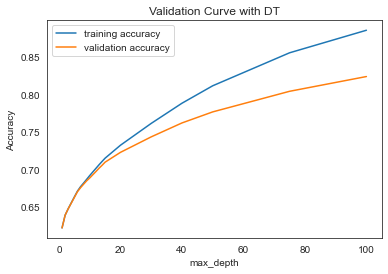

In [120]:
from sklearn.model_selection import validation_curve
param_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,40,50,75,100]

train_scores, valid_scores = validation_curve(estimator = DecisionTreeClassifier(random_state=1), X= X_train_bigram, 
                                              y = Y_train, param_name = "max_depth", param_range = param_range, 
                                           scoring='accuracy', cv=3)

train_scores = np.sqrt(np.abs(train_scores))
valid_scores = np.sqrt(np.abs(valid_scores))

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.title("Validation Curve with DT")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.plot(param_range, train_scores_mean, label="training accuracy")
plt.plot(param_range, valid_scores_mean, label="validation accuracy")

plt.legend()
plt.show()

In [142]:
dt_bigram = DecisionTreeClassifier(max_depth = 20)
dt_bigram.fit(X_train_bigram, Y_train)

DecisionTreeClassifier(max_depth=20)

In [143]:
pred = dt_bigram.predict(X_test_bigram)

In [144]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

        -1.0       0.64      0.23      0.34     30268
         0.0       0.02      0.82      0.05       801
         1.0       0.58      0.45      0.51     32741

    accuracy                           0.35     63810
   macro avg       0.42      0.50      0.30     63810
weighted avg       0.60      0.35      0.42     63810



In [145]:
#Preforming 10-fold Cross validation
accuracies = cross_val_score(estimator = dt_bigram, X = X_train_bigram, y = Y_train, cv = 10, scoring = 'accuracy')
print(accuracies)
print(accuracies.mean())

[0.52942204 0.53234678 0.53540248 0.52702113 0.52566789 0.52339794
 0.52833071 0.52248123 0.52684652 0.48218963]
0.5233106338397067


In [146]:
precision = cross_val_score(estimator = dt_bigram, X = X_train_bigram, y = Y_train, scoring="precision_macro", cv = 10)
print(precision)
print(precision.mean())

[0.56326694 0.55606018 0.5608641  0.56311916 0.55061307 0.57371541
 0.55771435 0.56572181 0.55113018 0.50352307]
0.5545728274077745


In [ ]:
recall = cross_val_score(estimator = dt_bigram, X = X_train_bigram, y = Y_train, scoring="recall_macro", cv = 10)
print(recall)
print(recall.mean())

In [ ]:
f1 = cross_val_score(estimator = dt_bigram, X = X_train_bigram, y = Y_train, scoring="f1_macro", cv = 10)
print(f1)
print(f1.mean())

<h4>LR</h4>

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [116]:
lr_bigram = LogisticRegression(multi_class='multinomial', solver='lbfgs',  C=1.0, max_iter = 1000).fit(X_train_bigram, Y_train) 
pred = lr_bigram.predict(X_test_bigram)

In [117]:
print("Accuracy: %s" % str(lr_bigram.score(X_test_bigram, Y_test))) #check accuracy
print("Confusion Matrix") 
print(confusion_matrix(pred, Y_test))

Accuracy: 0.8720106566368908
Confusion Matrix
[[26555    61  3223]
 [  663   759  1232]
 [ 2953    35 28329]]


In [118]:
from sklearn.metrics import classification_report
from sklearn import metrics

print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

        -1.0       0.89      0.88      0.89     30171
         0.0       0.29      0.89      0.43       855
         1.0       0.90      0.86      0.88     32784

    accuracy                           0.87     63810
   macro avg       0.69      0.88      0.73     63810
weighted avg       0.89      0.87      0.88     63810



In [122]:
accuracies = cross_val_score(estimator = lr_bigram, X = X_train_bigram, y = Y_train, cv = 5, scoring = 'accuracy')

print("Accuracies:", accuracies)
print("Mean:", accuracies.mean())

Accuracies: [0.88925771 0.88770474 0.89087137 0.88884036 0.81284123]
Mean: 0.8739030825170806
